# Objetivos deste trabalho:
- Se familiarizar com o ambiente Notebook e com Python
- Implementar um perceptron simples, treiná-lo no conjunto de TREINO do CIFAR-10 e avaliá-lo no conjunto de TESTE (alvo: distinguir fotos de animais de meios de transporte)
- Utilizar a função sigmóide e verificar seu efeito no treinamento e na avaliação
- Modificar a metodologia para classificar cada classe individualmente (i.e. treinar 10 perceptrons, um para cada classe). Considerar: dado um exemplo, que passará por cada perceptron, como decidir qual é a classe dele?

In [1]:
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Carregar os datasets

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
print(len(dataset_train), len(dataset_test))

50000 10000


In [5]:
# Converter para tons de cinza

# Treino
grayscale_dataset_train = []
for img,label in dataset_train:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_train.append((gray_npimg,category))
    
# Teste
grayscale_dataset_test = []
for img,label in dataset_test:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_test.append((gray_npimg,category))    

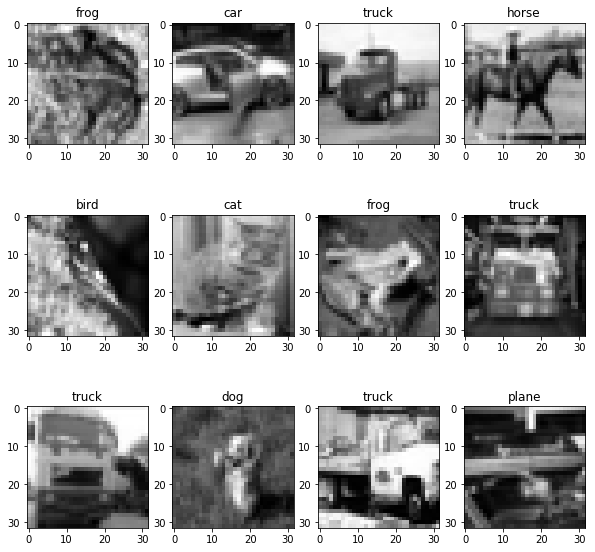

In [6]:
# Mostrar imagens

import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    image_index = random.randint(0, len(dataset_train))
    label = grayscale_dataset_train[image_index][1]
    npimg = grayscale_dataset_train[image_index][0]

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(npimg, cmap='gray')
    plt.title(label)
    
plt.show()

In [7]:
# Converter para vetores 1D

# Para pensar: por que a divisão por 255 no código abaixo?

linear_dataset_train = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_train:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_train.append((linear_img,label))
    
linear_dataset_test = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_test.append((linear_img,label))    

In [8]:
size = len(linear_dataset_train[0][0])
print(size)

1024


# Definindo o perceptron

In [9]:
class Perceptron(object):
    
    def __init__(self, neta=0.001):
        self.neta = neta
        self.weights = (np.random.rand(1,size) - 0.5)[0]
        bias = (np.random.rand(1) - 0.5) 
        self.weights = np.append(self.weights, bias) 
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def predict(self, inputs):
        o = np.dot(inputs, self.weights)
        y = self.sigmoid(o)
        return y
    

    def evaluate(self, dataset):
        hits = 0
        for image,label in dataset:
            image = np.append(image, 1)
            # Defina a métrica de avaliação do perceptron aqui (e.g. acurácia)
            y = self.predict(image)

            if(y >= 0.5 and label == 1):
                hits += 1

            elif(y < 0.5 and label == 0):
                hits += 1

        accuracy = hits / len(dataset)
        return accuracy
    
    
    def train(self, dataset, epochs=100, verbose="not_verbose"):
        np.random.shuffle(dataset)

        self.accuracies = []
        self.losses = []
        
        for epoch in range(epochs):
            hits = 0
            loss = 0
            for image, label in dataset:
                image = np.append(image, 1)

                y = self.predict(image)

                if(y >= 0.5 and label == 1):
                    hits += 1

                elif(y < 0.5 and label == 0):
                    hits += 1

                delta_weights = self.neta * (label - y) * image * y * (1 - y)
                self.weights += delta_weights
                loss += abs(label - y)

            accuracy = hits / len(linear_dataset_train)
            self.accuracies = np.append(self.accuracies, accuracy)
            self.losses = np.append(self.losses, loss)

            if(verbose == "verbose"):
                print(epoch,"\t", accuracy, "\t", loss)
            
    
    def plotResults(self):
        plt.plot(self.accuracies)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.show()

        plt.plot(self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

# Treinando o perceptron

In [10]:
p = Perceptron()
p.train(linear_dataset_train, 10, "verbose")

0 	 0.6596 	 19336.58209212752
1 	 0.69462 	 18077.935099060527
2 	 0.6999 	 17986.584742282303
3 	 0.7031 	 17976.30466459312
4 	 0.7054 	 17992.60170664875
5 	 0.70776 	 18012.376759447994
6 	 0.70986 	 18027.81317110317
7 	 0.71148 	 18037.569878134793
8 	 0.71252 	 18042.411364085736
9 	 0.71396 	 18043.501000721524


In [11]:
# Avalie o modelo treinado aqui
# Como a acurácia no conjunto de teste se compara com a acurácia obtida no conjunto de treino?

# A acurácia no conjunto de treino é maior devido ao overfitting do conjunto de treinamento.
# Analogamente, a acurácia do conjunto de teste é menor justamente pelo fato de que as imagens do 
# conjunto de teste nunca foram apresentadas ao modelo.

accuracy_train = p.evaluate(linear_dataset_train)
accuracy_test = p.evaluate(linear_dataset_test)

print("Train Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test)


Train Accuracy:  0.7191 	Test Accuracy:  0.7084


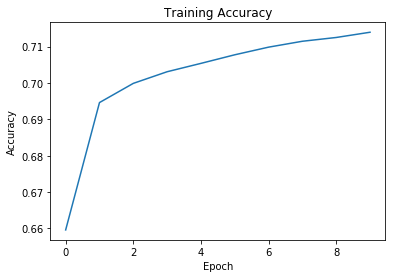

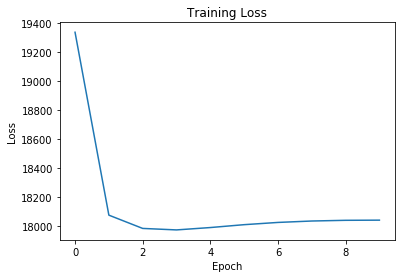

In [12]:
# Caso queiram plotar alguma coisa

p.plotResults()


# Classificando classes individuais

Implemente aqui a modificação do processo de avaliação e treinamento para poder classificar cada classe individualmente.

- Ideia geral: treinar um perceptron por classe (exemplo positivo = exemplos da classe; exemplos negativos = exemplo de todas outras classes)
- Dado um exemplo qualquer, como decidir qual perceptron está dando a classe correta?

In [13]:
def classes(x):
    return {
        0: "plane",
        1: "car",
        2: "bird",
        3: "cat",
        4: "deer",
        5: "dog",
        6: "frog",
        7: "horse",
        8: "ship",
        9: "truck",
    }[x]

In [14]:
# converter para vetores 1D

linear_dataset_array_train = [[] for i in range(10)]
linear_dataset_array_test = [[] for i in range(10)]

for index in range(10):
    
    target_labels = classes(index)
    for img,category in grayscale_dataset_train:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_train[index].append((linear_img,label))

    
    
    for img,category in grayscale_dataset_test:
        linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
        if category in target_labels:
            label = 1
        else:
            label = 0
        linear_dataset_array_test[index].append((linear_img,label))
    

############################################
Training Perceptron  0
0 	 0.89624 	 5774.631686005363
1 	 0.89962 	 5326.335041519456
2 	 0.8997 	 5320.309491770315
3 	 0.89976 	 5357.954905658746
4 	 0.8997 	 5425.071396810016
5 	 0.89962 	 5507.128546824018
6 	 0.89948 	 5584.485619185408
7 	 0.89934 	 5651.844026169485
8 	 0.89926 	 5716.471892109322
9 	 0.89914 	 5785.401802052207

Train Accuracy:  0.8991 	Test Accuracy:  0.8987 



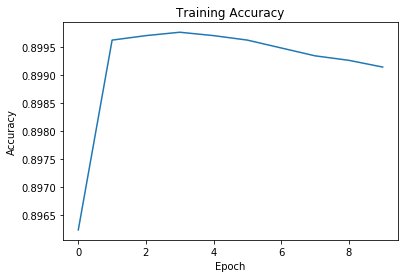

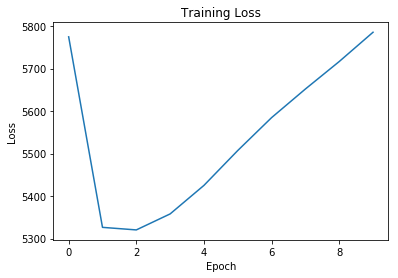




############################################
Training Perceptron  1
0 	 0.89346 	 6310.509797284103
1 	 0.89502 	 6550.516810124209
2 	 0.895 	 6812.697800321058
3 	 0.89548 	 6927.988823499161
4 	 0.89626 	 6981.917179467177
5 	 0.89688 	 7003.917631688393
6 	 0.89742 	 7009.228549652191
7 	 0.89792 	 7007.035961868954
8 	 0.89834 	 7002.28126352668
9 	 0.89896 	 6997.273235348724

Train Accuracy:  0.90018 	Test Accuracy:  0.8993 



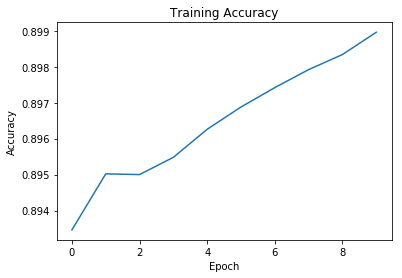

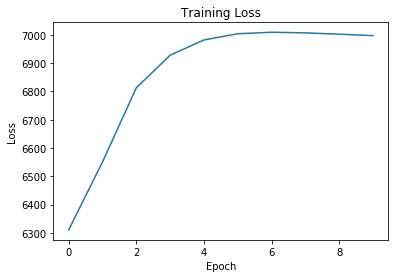




############################################
Training Perceptron  2
0 	 0.89588 	 5701.280961579729
1 	 0.89946 	 5323.659698867505
2 	 0.8995 	 5331.171737003932
3 	 0.8994 	 5368.672052639819
4 	 0.8994 	 5422.091587547482
5 	 0.89928 	 5487.3784710865975
6 	 0.89906 	 5563.2096507843835
7 	 0.89908 	 5649.566876020338
8 	 0.899 	 5747.540302996007
9 	 0.899 	 5859.312824723883

Train Accuracy:  0.89888 	Test Accuracy:  0.8989 



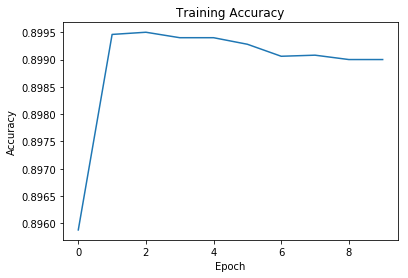

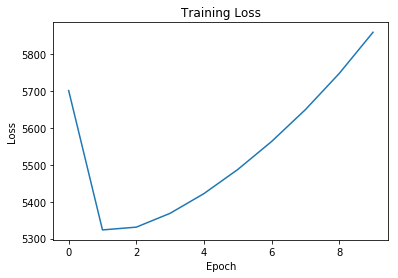




############################################
Training Perceptron  3
0 	 0.89806 	 5756.058291275905
1 	 0.89772 	 5833.428071468353
2 	 0.89756 	 5963.603663329739
3 	 0.8973 	 6069.196352195619
4 	 0.89714 	 6166.279129253107
5 	 0.89706 	 6261.283876310177
6 	 0.89714 	 6355.826800783948
7 	 0.89716 	 6449.677219808943
8 	 0.89716 	 6541.823394525761
9 	 0.8973 	 6630.894622379283

Train Accuracy:  0.89724 	Test Accuracy:  0.8983 



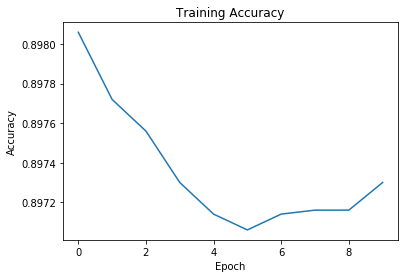

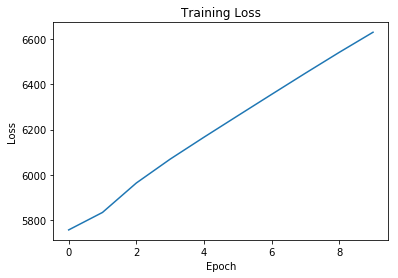




############################################
Training Perceptron  4
0 	 0.89534 	 5776.064177904296
1 	 0.89842 	 5545.512425296823
2 	 0.89698 	 5956.3528000265105
3 	 0.89628 	 6256.598028528223
4 	 0.89614 	 6371.602325272809
5 	 0.89606 	 6451.52331712438
6 	 0.896 	 6530.909161404138
7 	 0.89586 	 6612.812874388295
8 	 0.8958 	 6694.753283581426
9 	 0.89586 	 6774.62126846383

Train Accuracy:  0.89662 	Test Accuracy:  0.8975 



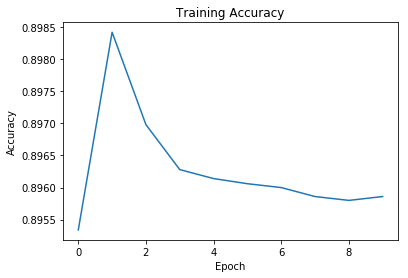

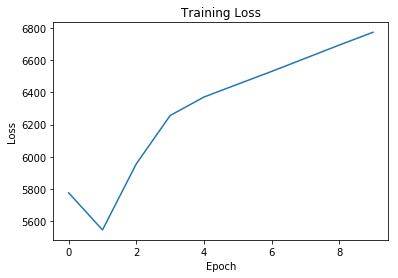




############################################
Training Perceptron  5
0 	 0.82764 	 9332.889194290385
1 	 0.89726 	 5938.900990676921
2 	 0.89714 	 6178.858812667651
3 	 0.89714 	 6417.575379066083
4 	 0.89704 	 6646.121164030267
5 	 0.89674 	 6859.936854018705
6 	 0.89644 	 7047.671359261763
7 	 0.8959 	 7193.264025021675
8 	 0.89534 	 7283.881005468742
9 	 0.89558 	 7322.8464791934975

Train Accuracy:  0.89676 	Test Accuracy:  0.8972 



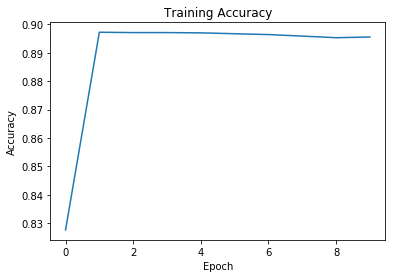

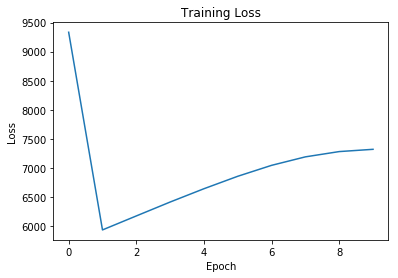




############################################
Training Perceptron  6
0 	 0.88838 	 6098.404305444542
1 	 0.89846 	 5520.306357586156
2 	 0.89806 	 5649.054698754407
3 	 0.8976 	 5825.585466653638
4 	 0.89732 	 6022.681157206973
5 	 0.897 	 6206.70527208262
6 	 0.89664 	 6360.033951923683
7 	 0.89642 	 6487.563227487667
8 	 0.89638 	 6598.634065754677
9 	 0.89636 	 6698.39237630228

Train Accuracy:  0.8965 	Test Accuracy:  0.8963 



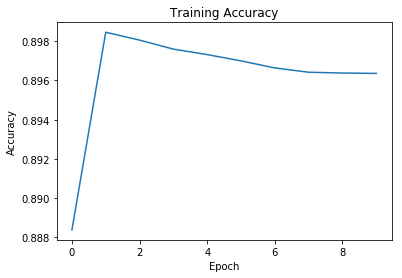

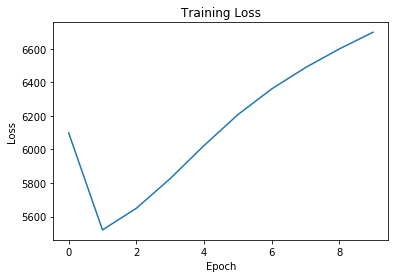




############################################
Training Perceptron  7
0 	 0.70932 	 15522.374126210523
1 	 0.89706 	 6566.875951830128
2 	 0.89698 	 6679.230817963259
3 	 0.89702 	 6737.343055091077
4 	 0.89734 	 6780.062573280957
5 	 0.8972 	 6809.204923863941
6 	 0.89736 	 6825.339357515123
7 	 0.89772 	 6832.300454642264
8 	 0.89822 	 6834.904177714055
9 	 0.89852 	 6836.39060049671

Train Accuracy:  0.89992 	Test Accuracy:  0.8982 



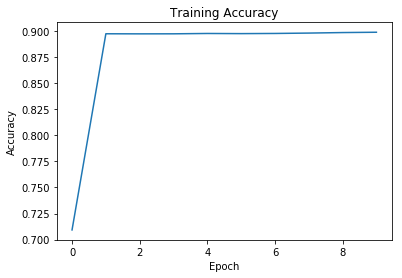

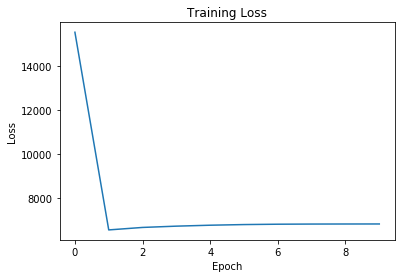




############################################
Training Perceptron  8
0 	 0.89852 	 5491.044007852089
1 	 0.89922 	 5366.452069213242
2 	 0.89926 	 5417.169736889335
3 	 0.89876 	 5604.085104232538
4 	 0.8974 	 6019.735515193907
5 	 0.89614 	 6372.235606645315
6 	 0.89574 	 6557.389281166585
7 	 0.8952 	 6702.894822802097
8 	 0.89482 	 6845.688956606742
9 	 0.89484 	 6984.287737601304

Train Accuracy:  0.8941 	Test Accuracy:  0.8945 



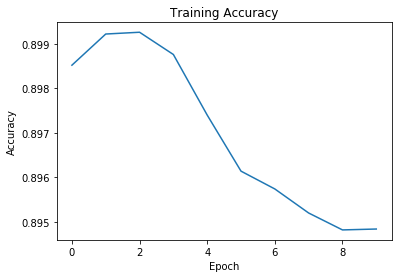

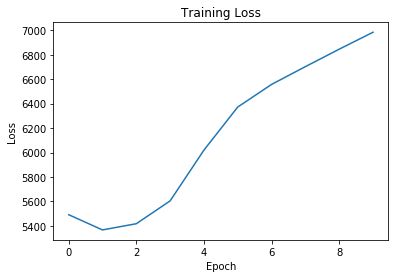




############################################
Training Perceptron  9
0 	 0.89462 	 6736.29406021788
1 	 0.89602 	 6591.996903407331
2 	 0.89656 	 6584.873798384393
3 	 0.89722 	 6605.717802719404
4 	 0.89808 	 6627.143206293588
5 	 0.89854 	 6643.032399391276
6 	 0.89868 	 6654.989518236619
7 	 0.89872 	 6665.661077163125
8 	 0.89918 	 6676.699952450718
9 	 0.8997 	 6688.732338567194

Train Accuracy:  0.90018 	Test Accuracy:  0.9016 



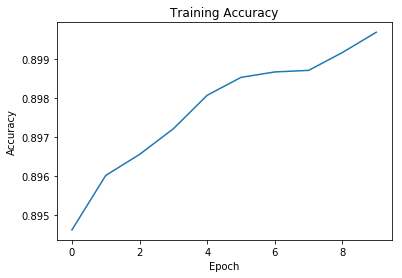

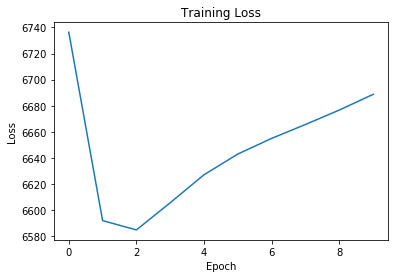

In [15]:
perceptrons = []

for index in range(10):
    print("############################################")
    print("Training Perceptron ", index)
    
    p0 = Perceptron()
    p0.train(linear_dataset_array_train[index], 10, "verbose")

    accuracy_train = p0.evaluate(linear_dataset_array_train[index])
    accuracy_test = p0.evaluate(linear_dataset_array_test[index])

    print("\nTrain Accuracy: ", accuracy_train, "\tTest Accuracy: ", accuracy_test, "\n")

    p0.plotResults()
    
    perceptrons = np.append(p0, perceptrons)
    print("\n\n")
